# Training VGG19

In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



X_train = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_train_256x192.npy")
y_train = np.load("/home/sajedhamdan/Desktop/skin_cancer/train_labels.npy")

X_val = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_val_256x192.npy")
y_val = np.load("/home/sajedhamdan/Desktop/skin_cancer/val_labels.npy")

X_train.shape, X_val.shape
y_train.shape, y_val.shape

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')


pretrained_model = VGG19(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

# freezing layer, thus pre trained model adapts to new tasks and prevent overfitting
for layer in pretrained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pretrained_model.layers))

last_layer = pretrained_model.get_layer('block5_pool')
print('Last layer output shape:', last_layer.output.shape)
last_output = last_layer.output



x = layers.GlobalMaxPooling2D()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)


input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
22
Last layer output shape: (None, 6, 8, 512)


In [4]:
# compiling model
model = Model(pretrained_model.input, x)
#changed epsilon from NONE to 1e-7, this helps not to divide by xero when updating class weight
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

batch_size = 64 
epochs = 3
# training model, with freezed layers for (first phase)
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=val_datagen.flow(X_val, y_val),
                    verbose=1,
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    validation_steps=(X_val.shape[0] // batch_size))

/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 877s 7s/step - accuracy: 0.5275 - loss: 1.5298 - precision: 0.5958 - recall: 0.4043 - val_accuracy: 0.6406 - val_loss: 1.1091 - val_precision: 0.6872 - val_recall: 0.6228
Epoch 2/3
  1/126 ━━━━━━━━━━━━━━━━━━━━ 13:30 6s/step - accuracy: 0.6875 - loss: 0.9791 - precision: 0.7551 - recall: 0.5781

/home/sajedhamdan/Desktop/skin_cancer/myvenv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 370ms/step - accuracy: 0.6875 - loss: 0.9791 - precision: 0.7551 - recall: 0.5781 - val_accuracy: 0.6540 - val_loss: 1.0683 - val_precision: 0.7032 - val_recall: 0.6451
Epoch 3/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 870s 7s/step - accuracy: 0.6584 - loss: 1.1272 - precision: 0.7088 - recall: 0.5861 - val_accuracy: 0.6853 - val_loss: 1.0039 - val_precision: 0.7379 - val_recall: 0.6473


In [6]:
for layer in model.layers[:15]:
    layer.trainable = False

# unfreezing last 15 layers, to avoid overfitting and fine tuning(improved accuracy)
for layer in model.layers[15:]:
    layer.trainable = True      


optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')] )                     



# drops learning rate when the model stops improving or is stuck
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

# retrain the model
batch_size = 64
epochs = 10
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[lr_reduction])                                            


                                                        

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1099s 9s/step - accuracy: 0.7009 - loss: 0.8217 - precision: 0.8165 - recall: 0.6089 - val_accuracy: 0.7098 - val_loss: 0.7936 - val_precision: 0.8233 - val_recall: 0.5826 - learning_rate: 1.0000e-04
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 359ms/step - accuracy: 0.7812 - loss: 0.6121 - precision: 0.9020 - recall: 0.7188 - val_accuracy: 0.6853 - val_loss: 0.8190 - val_precision: 0.8397 - val_recall: 0.5379 - learning_rate: 1.0000e-04
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1083s 9s/step - accuracy: 0.7317 - loss: 0.7383 - precision: 0.8416 - recall: 0.6431 - val_accuracy: 0.7299 - val_loss: 0.7406 - val_precision: 0.7939 - val_recall: 0.6362 - learning_rate: 1.0000e-04
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 359ms/step - accuracy: 0.6875 - loss: 0.7063 - precision: 0.8511 - recall: 0.6250 - val_accuracy: 0.7210 - val_loss: 0.7561 - val_precision: 0.8230 - val_recall: 0.6228 - learning_rate: 1.0000e-04
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━

In [7]:
results = model.evaluate(X_val, y_val, verbose=1)
loss_val = results[0]
acc_val = results[1]
precision_val = results[2]
recall_val = results[3]

print("Validation: accuracy = %f  ;  loss = %f  ;  precision = %f  ;  recall = %f"
      % (acc_val, loss_val, precision_val, recall_val))   

29/29 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7492 - loss: 0.7046 - precision: 0.8154 - recall: 0.6886
Validation: accuracy = 0.733925  ;  loss = 0.714568  ;  precision = 0.812749  ;  recall = 0.678492


# Testing VGG19

In [8]:
import matplotlib.pyplot as plt

X_test = np.load("/home/sajedhamdan/Desktop/skin_cancer/images_test_256x192.npy")

y_test = np.load("/home/sajedhamdan/Desktop/skin_cancer/test_labels.npy")
y_test = to_categorical(y_test)


results = model.evaluate(X_test, y_test, verbose=1)

# Unpack individual metrics from the results list
loss_test = results[0]
accuracy_test = results[1]
precision_test = results[2]
recall_test = results[3]

print("Test: accuracy = %f  ;  loss = %f  ;  precision = %f  ;  recall = %f"
      % (accuracy_test, loss_test, precision_test, recall_test))


model.save("VGG19.h5")

32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.7340 - loss: 0.7168 - precision: 0.8027 - recall: 0.6661


Test: accuracy = 0.751497  ;  loss = 0.696461  ;  precision = 0.813018  ;  recall = 0.685629


Text(0.5, 1.0, 'Training and validation loss')

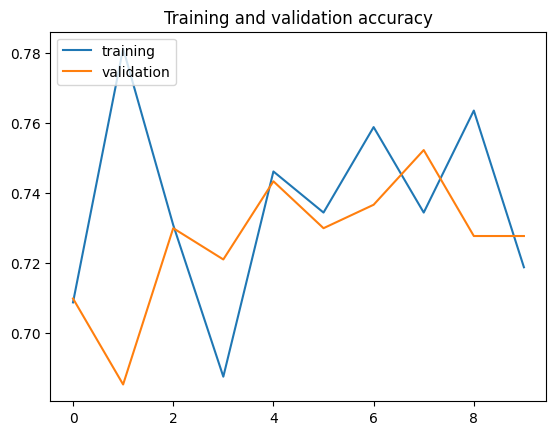

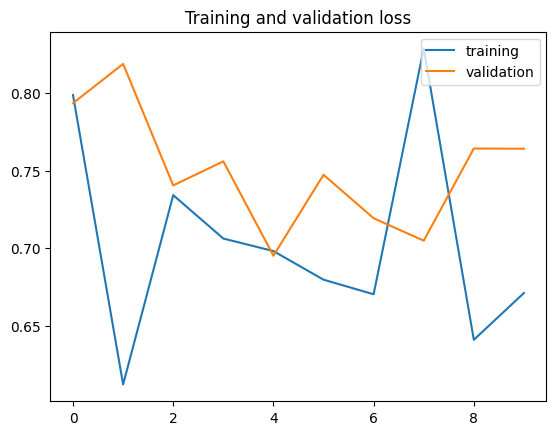

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label="training")
plt.plot(epochs, val_acc, label="validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label="training")
plt.plot(epochs, val_loss, label="validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')
